In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import copy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

In [2]:
#0 female 96,1 male 207
dataset = pd.read_csv("heart.csv")
dataset = dataset[dataset['sex'] != 0]
dataset= dataset.drop('sex', axis=1)
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
heart_test=test_set
heart_data=train_set

In [3]:
# dataset[dataset['sex'] != 0].shape

In [4]:
heart_test.shape

(42, 13)

In [5]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 157 to 175
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       165 non-null    int64  
 1   cp        165 non-null    int64  
 2   trtbps    165 non-null    int64  
 3   chol      165 non-null    int64  
 4   fbs       165 non-null    int64  
 5   restecg   165 non-null    int64  
 6   thalachh  165 non-null    int64  
 7   exng      165 non-null    int64  
 8   oldpeak   165 non-null    float64
 9   slp       165 non-null    int64  
 10  caa       165 non-null    int64  
 11  thall     165 non-null    int64  
 12  output    165 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 18.0 KB


In [6]:
heart_data.shape

(165, 13)

In [7]:
heart_data

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
157,35,1,122,192,0,1,174,0,0.0,2,0,2,1
295,63,0,140,187,0,0,144,1,4.0,2,2,3,0
111,57,2,150,126,1,1,173,0,0.2,2,1,3,1
149,42,2,130,180,0,1,150,0,0.0,2,0,2,1
299,45,3,110,264,0,1,132,0,1.2,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,57,0,150,276,0,0,112,1,0.6,1,1,1,0
23,61,2,150,243,1,1,137,1,1.0,1,0,2,1
164,38,2,138,175,0,1,173,0,0.0,2,4,2,1
269,56,0,130,283,1,0,103,1,1.6,0,0,3,0


# Data visualization and some preanalysis
1. age - age in years

2. sex - sex (1 = male; 0 = female)($\color \red{\text{number works as label}}$)

3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)($\color \red{\text{number works as label}}$)

4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)

5. chol - serum cholestoral in mg/dl

6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)($\color \red{\text{number works as label}}$)

7. restecg - resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)($\color \red{\text{number works as label}}$)

8. thalach - maximum heart rate achieved

9. exang - exercise induced angina (1 = yes; 0 = no)($\color \red{\text{number works as label}}$)

10. oldpeak - ST depression induced by exercise relative to rest

11. slope - the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)($\color \red{\text{number works as label}}$)

12. caa - number of major vessels (0-3) colored by flourosopy

13. thal - 2 = normal; 1 = fixed defect; 3 = reversable defect($\color \red{\text{number works as label}}$)

14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

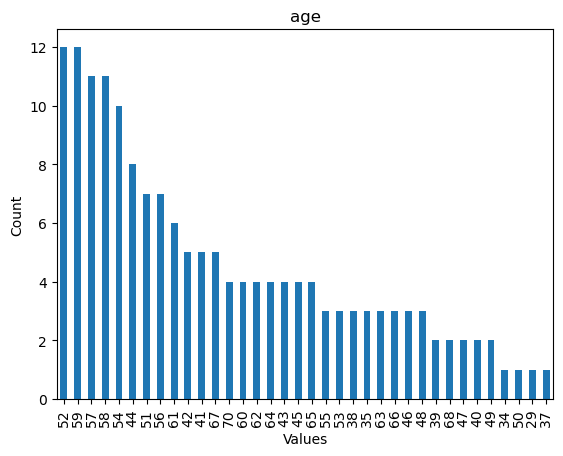

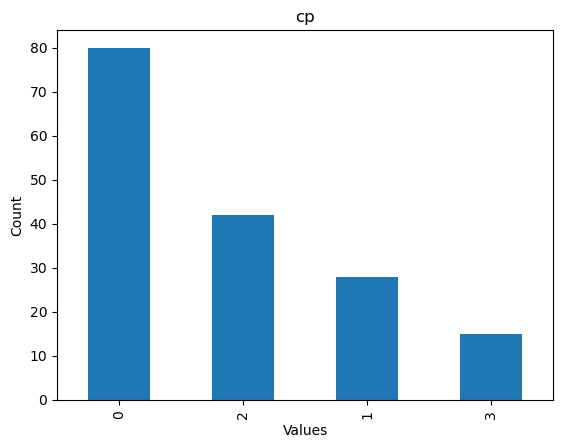

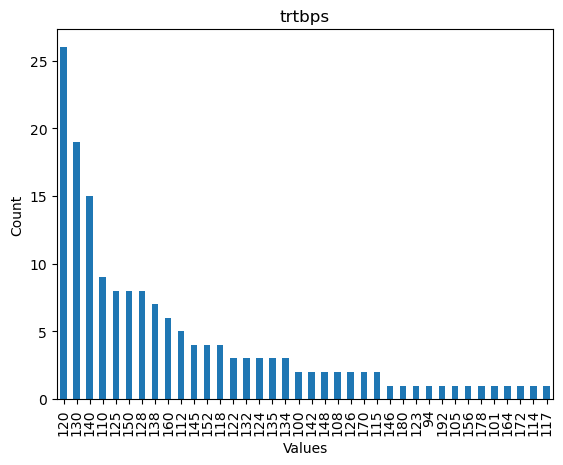

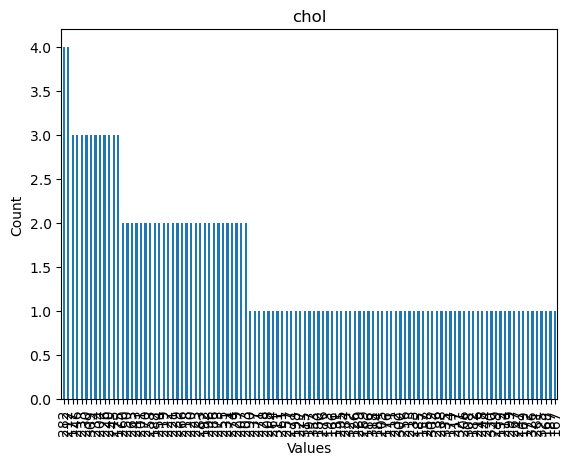

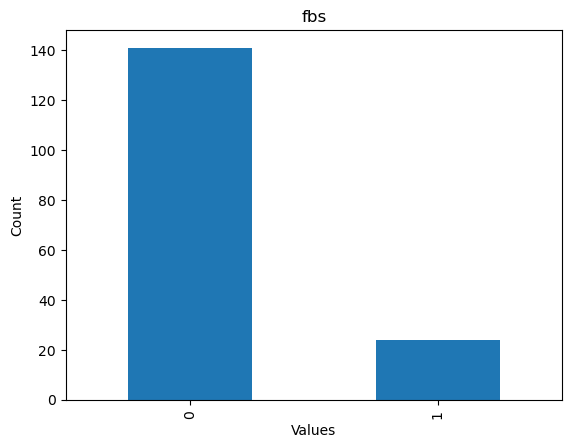

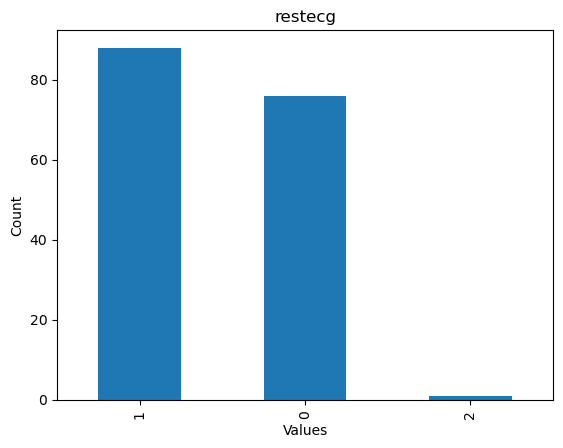

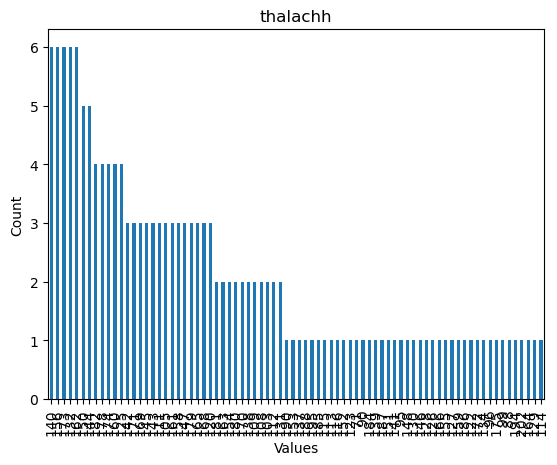

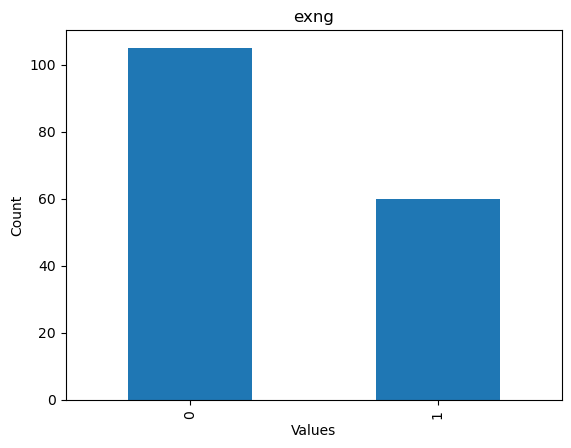

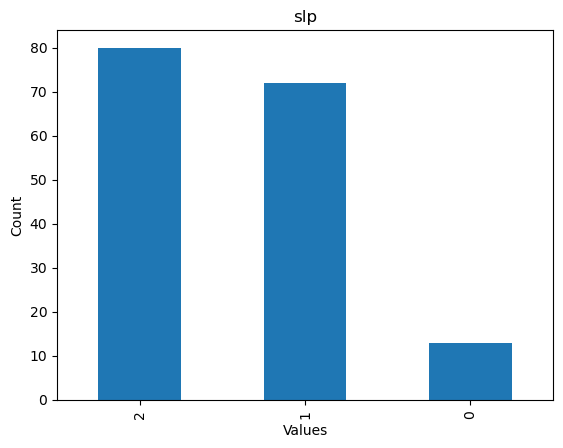

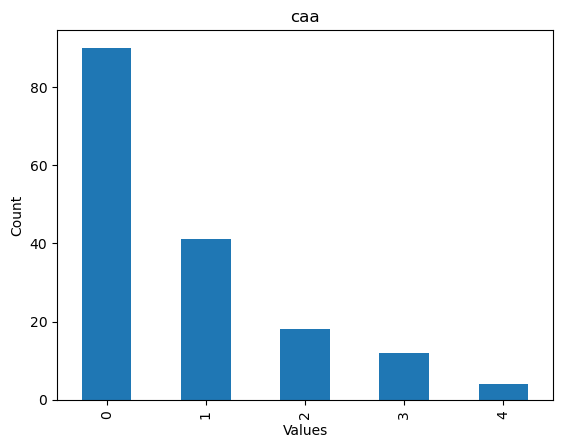

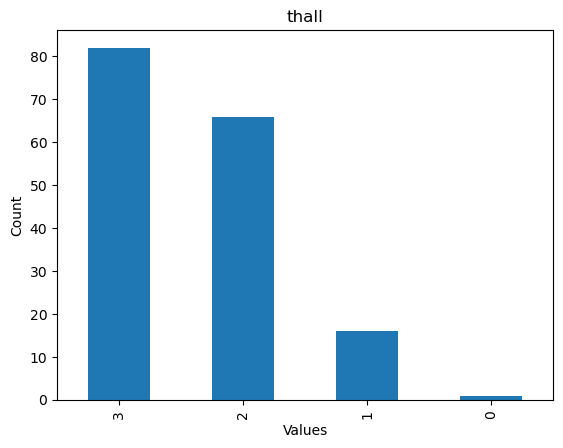

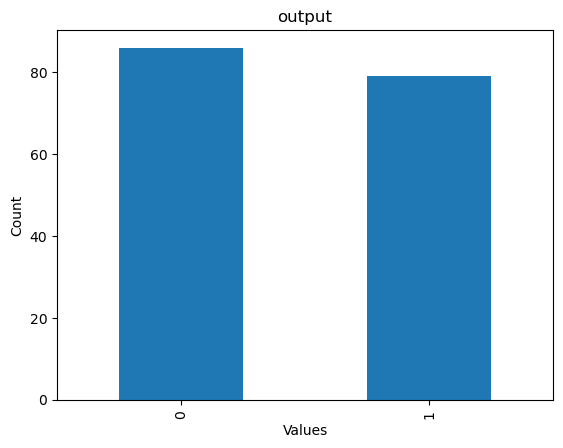

In [8]:
import matplotlib.pyplot as plt
categorical_columns = [col for col in heart_data.columns.values if heart_data[col].dtype == 'int64']

for col in categorical_columns:
    column_data = heart_data[col] 

    # calculate the number of each value
    value_counts = column_data.value_counts()

    # show the barplot
    value_counts.plot(kind='bar')
    plt.xlabel('Values')
    plt.ylabel('Count')
    plt.title(col)
    plt.show()

In [9]:
heart_data.describe()

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,53.563636,0.951515,131.218182,238.993939,0.145455,0.545455,148.842424,0.363636,1.103030,1.406061,0.781818,2.387879,0.478788
std,8.850583,1.052326,16.624282,43.715334,0.353632,0.511508,25.721290,0.482510,1.183032,0.633390,1.059641,0.685991,0.501071
min,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,0.000000,120.000000,208.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,130.000000,235.000000,0.000000,1.000000,151.000000,0.000000,0.800000,1.000000,0.000000,2.000000,0.000000
75%,59.000000,2.000000,140.000000,270.000000,0.000000,1.000000,169.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,70.000000,3.000000,192.000000,353.000000,1.000000,2.000000,202.000000,1.000000,5.600000,2.000000,4.000000,3.000000,1.000000


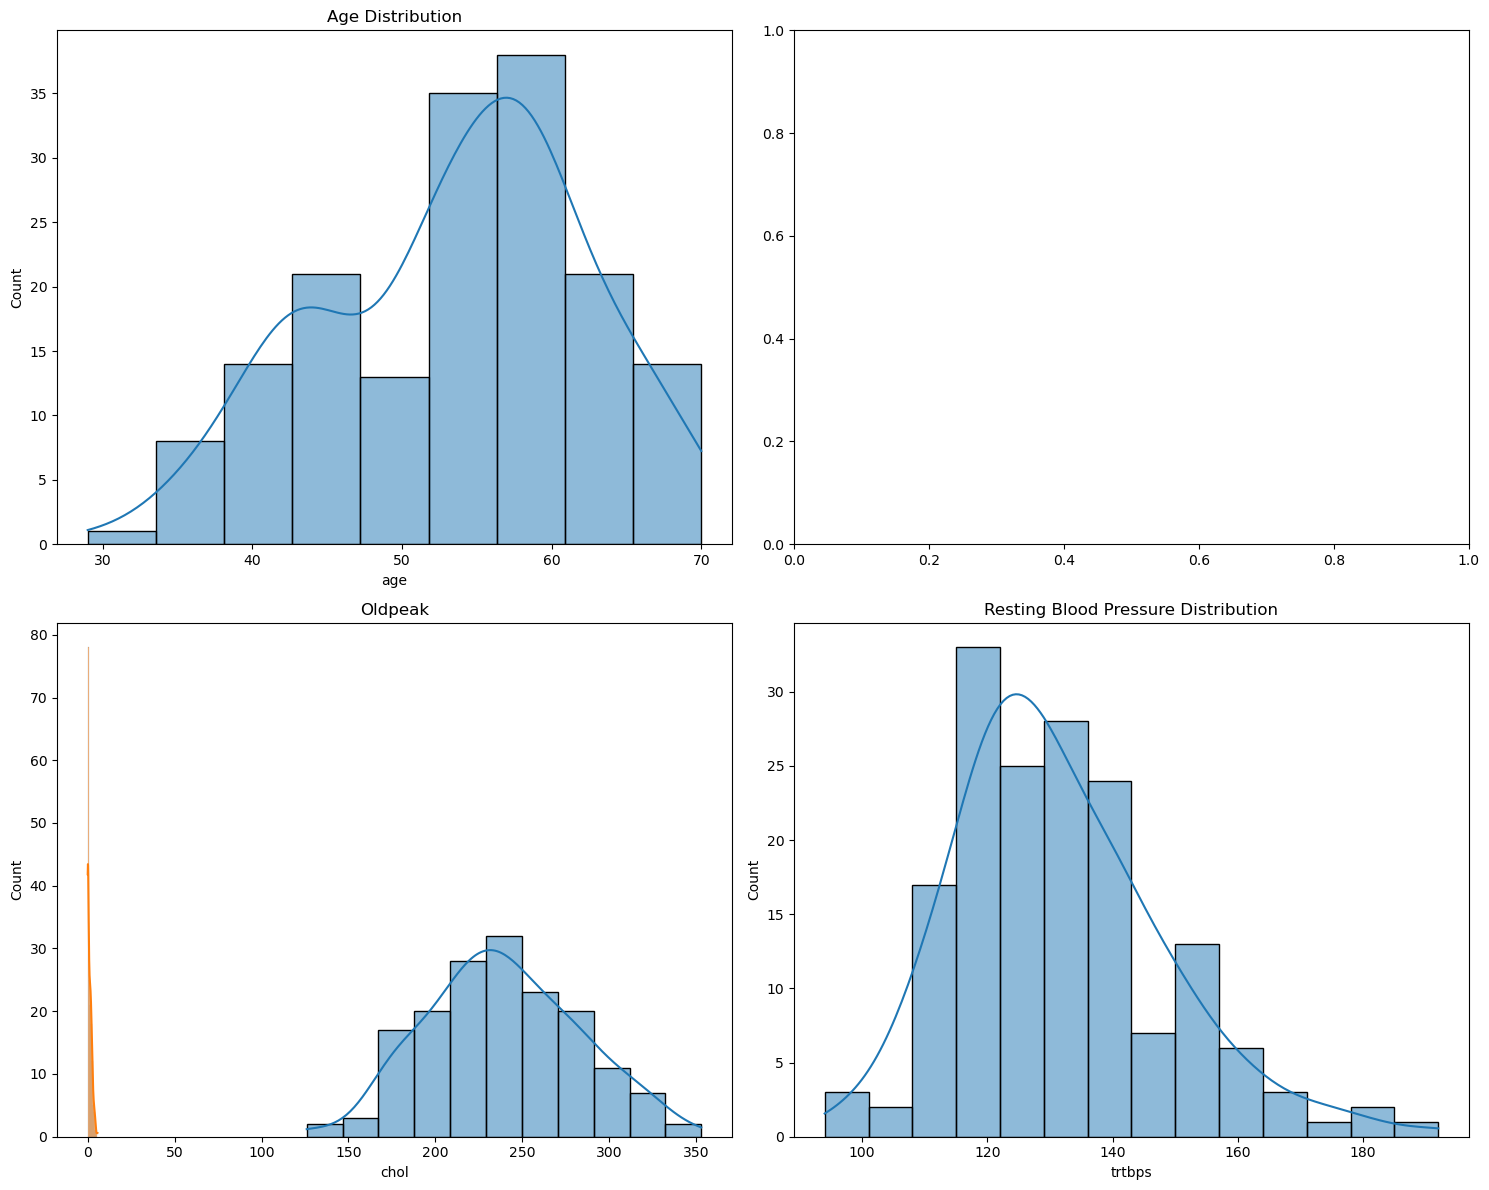

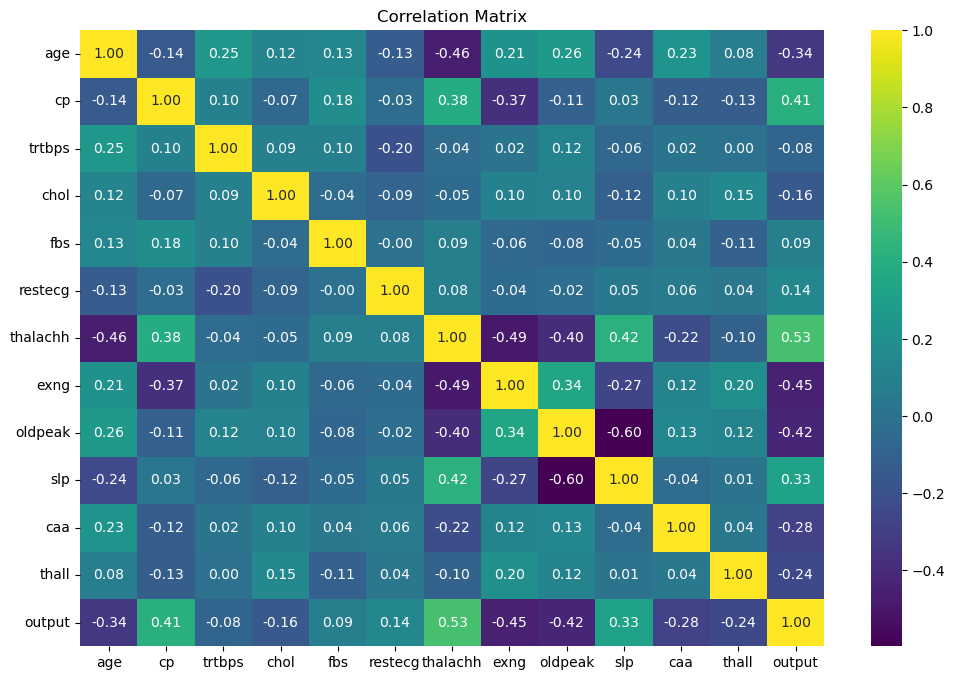

In [10]:
# Descriptive Analysis - Distribution of Key Variables
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.histplot(heart_data['age'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')

# sns.countplot(x='sex', data=heart_data, ax=axes[0, 1])
# axes[0, 1].set_title('Sex Distribution (0 = Female, 1 = Male)')

sns.histplot(heart_data['chol'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Cholesterol Level Distribution')

sns.histplot(heart_data['trtbps'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Resting Blood Pressure Distribution')

sns.histplot(heart_data['oldpeak'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Oldpeak')

plt.tight_layout()

# Correlation Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(heart_data.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title("Correlation Matrix")

plt.show()

In [11]:
heart_data

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
157,35,1,122,192,0,1,174,0,0.0,2,0,2,1
295,63,0,140,187,0,0,144,1,4.0,2,2,3,0
111,57,2,150,126,1,1,173,0,0.2,2,1,3,1
149,42,2,130,180,0,1,150,0,0.0,2,0,2,1
299,45,3,110,264,0,1,132,0,1.2,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,57,0,150,276,0,0,112,1,0.6,1,1,1,0
23,61,2,150,243,1,1,137,1,1.0,1,0,2,1
164,38,2,138,175,0,1,173,0,0.0,2,4,2,1
269,56,0,130,283,1,0,103,1,1.6,0,0,3,0


### Create normalized dataset
Here I try to apply Min-Max approach.
$$v'=\frac{v-min_A}{max_A-min_A}(newmax_A-newmin_A)+newmin_A$$

In [12]:
def min_max_normalization(df):
    df=df.iloc[:,:-1]
    min_vals = df.min()
    max_vals = df.max()
    range_vals = max_vals - min_vals
    normalized_df = (df - min_vals) / range_vals
    return normalized_df
def z_score_normalize(df):
    df=df.iloc[:,:-1]
    normalized_values = (df - df.mean()) / df.std()
    normalized_df = pd.DataFrame(normalized_values, columns=df.columns)
    return normalized_df

In [13]:
n_data=min_max_normalization(heart_data)
n_data = pd.concat([n_data, heart_data["output"]], axis=1)
z_data=z_score_normalize(heart_data)
z_data = pd.concat([z_data, heart_data["output"]], axis=1)
n_test=min_max_normalization(heart_test)
n_test = pd.concat([n_test, heart_test["output"]], axis=1)
z_test=z_score_normalize(heart_test)
z_test = pd.concat([z_test, heart_test["output"]], axis=1)

In [14]:
z_data

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
157,-2.097448,0.046074,-0.554501,-1.074999,-0.411316,0.888637,0.978084,-0.753635,-0.932376,0.937716,-0.737815,-0.565428,1
295,1.066186,-0.904201,0.528252,-1.189375,-0.411316,-1.066365,-0.188265,1.318861,2.448768,0.937716,1.149618,0.892316,0
111,0.388264,0.996349,1.129782,-2.584767,2.416484,0.888637,0.939205,-0.753635,-0.763319,0.937716,0.205902,0.892316,1
149,-1.306540,0.996349,-0.073277,-1.349502,-0.411316,0.888637,0.045005,-0.753635,-0.932376,0.937716,-0.737815,-0.565428,1
299,-0.967579,1.946625,-1.276337,0.572020,-0.411316,0.888637,-0.654805,-0.753635,0.081967,-0.641091,-0.737815,0.892316,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.388264,-0.904201,1.129782,0.846524,-0.411316,-1.066365,-1.432371,1.318861,-0.425204,-0.641091,0.205902,-2.023173,0
23,0.840212,0.996349,1.129782,0.091640,2.416484,0.888637,-0.460413,1.318861,-0.087090,-0.641091,-0.737815,-0.565428,1
164,-1.758487,0.996349,0.407947,-1.463879,-0.411316,0.888637,0.939205,-0.753635,-0.932376,0.937716,3.037050,-0.565428,1
269,0.275277,-0.904201,-0.073277,1.006650,2.416484,-1.066365,-1.782275,1.318861,0.420081,-2.219898,-0.737815,0.892316,0


# DBSCAN to remove the outlier

So before apply DBSCAN, I first try to normalize the data first, to make them less affected by some of the attributes.

In [15]:
dbsdata=heart_data
# Create a DBSCAN object
dbscan = DBSCAN(eps=27, min_samples=5)

# Fit the DBSCAN model to the data
dbscan.fit(dbsdata.iloc[:,:-1])

# Get the labels assigned to each data point
labels = dbscan.labels_

# Identify the indices of the outliers (points labeled as -1)
outlier_indices = labels == -1

# Remove the outliers from the dataset
new_data = dbsdata[~outlier_indices]

In [16]:
sum(outlier_indices==False)

158

Here we apply the PCA method to reduce the dimension of the data, to show how the clusters looks like

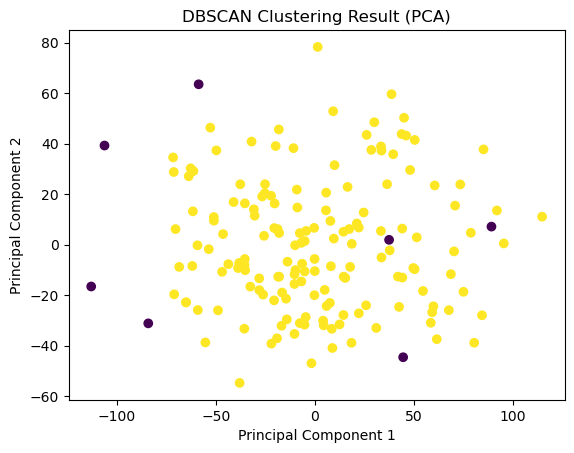

In [17]:
# Apply PCA to reduce the dimensionality
pca = PCA(n_components=3)
data_pca = pca.fit_transform(dbsdata)

# Plot the data points with colors representing their cluster labels
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering Result (PCA)')
plt.show()

In [18]:
heart_data.columns

Index(['age', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng',
       'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [19]:
heart_data

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
157,35,1,122,192,0,1,174,0,0.0,2,0,2,1
295,63,0,140,187,0,0,144,1,4.0,2,2,3,0
111,57,2,150,126,1,1,173,0,0.2,2,1,3,1
149,42,2,130,180,0,1,150,0,0.0,2,0,2,1
299,45,3,110,264,0,1,132,0,1.2,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,57,0,150,276,0,0,112,1,0.6,1,1,1,0
23,61,2,150,243,1,1,137,1,1.0,1,0,2,1
164,38,2,138,175,0,1,173,0,0.0,2,4,2,1
269,56,0,130,283,1,0,103,1,1.6,0,0,3,0


In [20]:
heart_data=new_data
new_data.shape

(158, 13)

In [21]:
heart_data

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
157,35,1,122,192,0,1,174,0,0.0,2,0,2,1
295,63,0,140,187,0,0,144,1,4.0,2,2,3,0
149,42,2,130,180,0,1,150,0,0.0,2,0,2,1
299,45,3,110,264,0,1,132,0,1.2,1,0,3,0
284,61,0,140,207,0,0,138,1,1.9,2,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,57,0,150,276,0,0,112,1,0.6,1,1,1,0
23,61,2,150,243,1,1,137,1,1.0,1,0,2,1
164,38,2,138,175,0,1,173,0,0.0,2,4,2,1
269,56,0,130,283,1,0,103,1,1.6,0,0,3,0


# $$\color \red{Approach\ one}$$

# Single linkage to cluster the attribute

Cluster 11: ['age']
Cluster 8: ['cp']
Cluster 1: ['trtbps']
Cluster 12: ['chol']
Cluster 9: ['fbs']
Cluster 5: ['restecg']
Cluster 2: ['thalachh']
Cluster 6: ['exng']
Cluster 10: ['oldpeak']
Cluster 3: ['slp']
Cluster 7: ['caa']
Cluster 4: ['thall']


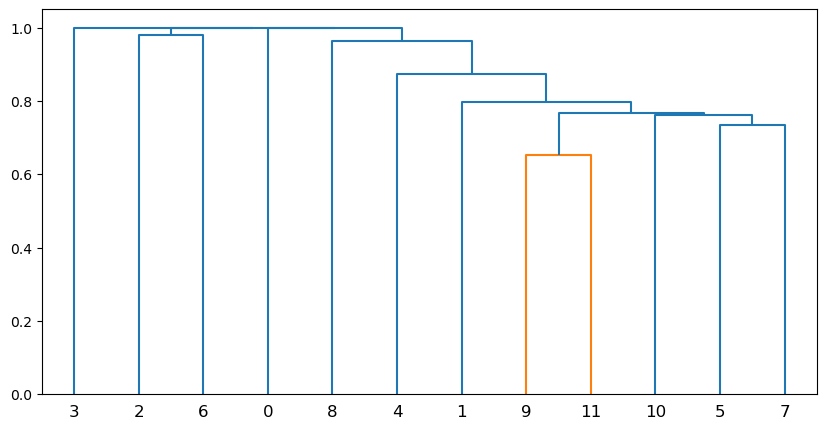

In [22]:
# Compute the pairwise distance matrix using single linkage method
df=heart_data.iloc[:, :-1]
distance_matrix = linkage(df.T, method='single', metric='jaccard')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dend = dendrogram(distance_matrix)

# Set the desired distance threshold
threshold = 0.6

# Get the attribute clusters at the specific threshold
clusters = fcluster(distance_matrix, t=threshold, criterion='distance')

# Determine attribute clusters based on cluster labels
attribute_clusters = {}
for attribute, cluster_label in zip(df.columns, clusters):
    if cluster_label not in attribute_clusters:
        attribute_clusters[cluster_label] = []
    attribute_clusters[cluster_label].append(attribute)

# Print the attribute clusters
for cluster_label, attributes in attribute_clusters.items():
    print(f'Cluster {cluster_label}: {attributes}')

In [23]:
attribute_clusters

{11: ['age'],
 8: ['cp'],
 1: ['trtbps'],
 12: ['chol'],
 9: ['fbs'],
 5: ['restecg'],
 2: ['thalachh'],
 6: ['exng'],
 10: ['oldpeak'],
 3: ['slp'],
 7: ['caa'],
 4: ['thall']}

In [24]:
heart_data

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
157,35,1,122,192,0,1,174,0,0.0,2,0,2,1
295,63,0,140,187,0,0,144,1,4.0,2,2,3,0
149,42,2,130,180,0,1,150,0,0.0,2,0,2,1
299,45,3,110,264,0,1,132,0,1.2,1,0,3,0
284,61,0,140,207,0,0,138,1,1.9,2,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,57,0,150,276,0,0,112,1,0.6,1,1,1,0
23,61,2,150,243,1,1,137,1,1.0,1,0,2,1
164,38,2,138,175,0,1,173,0,0.0,2,4,2,1
269,56,0,130,283,1,0,103,1,1.6,0,0,3,0


# Cluster the attributes based on dissimilarity

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster Labels:
[3 2 1 1 2 1 1 2 0 0 2 1]


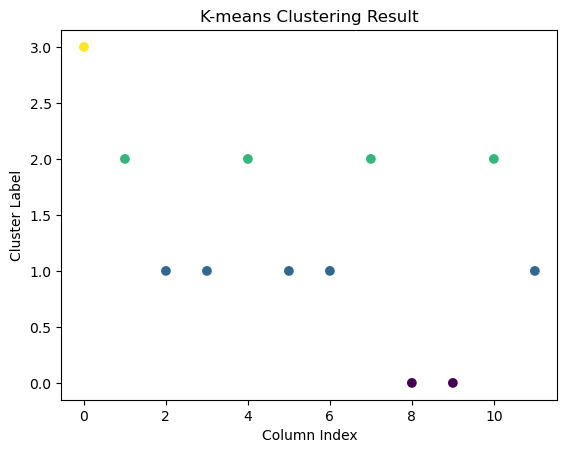

In [25]:
def kmeans_clustering(distance_matrix, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='random', n_init=10, random_state=42)
    kmeans.fit(distance_matrix)
    labels = kmeans.labels_
    return labels
n_clusters =4
distance_matrix=cosine_similarity(heart_data.iloc[:,:-1].T)
np.fill_diagonal(distance_matrix, 0)
# print(distance_matrix)
cluster_labels = kmeans_clustering(distance_matrix, n_clusters)

print("Cluster Labels:")
print(cluster_labels)
plt.scatter(range(len(cluster_labels)), cluster_labels, c=cluster_labels, cmap='viridis')
plt.xlabel('Column Index')
plt.ylabel('Cluster Label')
plt.title('K-means Clustering Result')
plt.show()

# Feature bagging
Here I am going to use feature bagging to solve the problem, based on the clustering result getting by single linkage clustering.

$$\color\red{Naive\ bagging\ approach}$$

In [26]:
# Create a list to store the classifiers
classifiers = []

# Iterate over attribute clusters and create a Decision Tree classifier for each cluster
for cluster_label, attributes in attribute_clusters.items():
    # Subset the data to the attributes in the current cluster
    cluster_data = heart_data[attributes + ['output']]
    X = cluster_data.drop('output', axis=1)
    y = cluster_data['output']
    # Create a Decision Tree classifier for the current cluster
    classifier = DecisionTreeClassifier()
    classifier.fit(X, y)
    print(attributes)
    # Add the classifier to the list
    classifiers.append(('cluster_' + str(cluster_label), classifier))

# Create the Voting Classifier using the list of classifiers
voting_classifier = VotingClassifier(classifiers, voting='hard')

# Fit the Voting Classifier to the data
X = heart_data.iloc[:, :-1]
y = heart_data['output']
voting_classifier.fit(X, y)
test=heart_test
# Predict the class labels using the Voting Classifier
predictions = voting_classifier.predict(test.iloc[:,:-1])
print('Predictions:', predictions)

# Create a list to store the true labels
true_labels = test['output'].values

# Evaluate the performance of the voting classifier
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Print the evaluation metrics
print('Evaluation Metrics:')
print('-------------------')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

['age']
['cp']
['trtbps']
['chol']
['fbs']
['restecg']
['thalachh']
['exng']
['oldpeak']
['slp']
['caa']
['thall']
Predictions: [1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0
 0 1 1 1 1]
Evaluation Metrics:
-------------------
Accuracy: 0.69
Precision: 0.53
Recall: 0.71
F1-Score: 0.61


In [27]:
heart_test

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
245,48,0,124,274,0,0,166,0,0.5,1,0,3,0
24,40,3,140,199,0,1,178,1,1.4,2,0,3,1
126,47,0,112,204,0,1,143,0,0.1,2,0,2,1
169,53,0,140,203,1,0,155,1,3.1,0,0,3,0
251,43,0,132,247,1,0,143,1,0.1,1,4,3,0
13,64,3,110,211,0,0,144,1,1.8,1,0,2,1
173,58,2,132,224,0,0,173,0,3.2,2,2,3,0
214,56,0,125,249,1,0,144,1,1.2,1,1,2,0
29,53,2,130,197,1,0,152,0,1.2,0,0,2,1
231,57,0,165,289,1,0,124,0,1.0,1,3,3,0


$$\color\red{Innovative\ bagging\ approach}$$

In [28]:
# Create a list to store the classifiers
classifiers = []
# Select columns based on the cluster number
for cluster_number in range (0,n_clusters):
    selected_columns = heart_data.iloc[:,:-1].columns[cluster_labels==cluster_number]
    subset_data = heart_data[selected_columns]
    # Extract the target variable
    target = heart_data['output']
    features = subset_data

    # Build the decision tree classifier
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(features, target)
    classifiers.append(('cluster_' + str(selected_columns.tolist()), decision_tree))

voting_classifier = VotingClassifier(classifiers, voting='hard')

# Fit the Voting Classifier to the data
X = heart_data.iloc[:, :-1]
y = heart_data['output']
voting_classifier.fit(X, y)
test=heart_test
# Predict the class labels using the Voting Classifier
predictions = voting_classifier.predict(test.iloc[:,:-1])
print('Predictions:', predictions)

# Create a list to store the true labels
true_labels = test['output'].values

# Evaluate the performance of the voting classifier
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Print the evaluation metrics
print('Evaluation Metrics:')
print('-------------------')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')


Predictions: [1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0
 1 1 1 1 1]
Evaluation Metrics:
-------------------
Accuracy: 0.67
Precision: 0.50
Recall: 0.71
F1-Score: 0.59


In [29]:
z_test

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
245,-0.718463,-0.782916,-0.346944,0.851987,-0.515978,-0.736429,0.991963,-0.814745,-0.575764,-0.512136,-0.818369,0.995580,0
24,-1.599497,1.957289,0.596969,-1.052739,-0.515978,1.325573,1.710281,1.198155,0.204303,1.142457,-0.818369,0.995580,1
126,-0.828592,-0.782916,-1.054879,-0.925757,-0.515978,1.325573,-0.384813,-0.814745,-0.922460,1.142457,-0.818369,-0.822436,1
169,-0.167816,-0.782916,0.596969,-0.951154,1.891921,-0.736429,0.333505,1.198155,1.677763,-2.166729,-0.818369,0.995580,0
251,-1.269109,-0.782916,0.125012,0.166286,1.891921,-0.736429,-0.384813,1.198155,-0.922460,-0.512136,2.706912,0.995580,0
13,1.043606,1.957289,-1.172868,-0.747983,-0.515978,-0.736429,-0.324953,1.198155,0.551000,-0.512136,-0.818369,-0.822436,1
173,0.382831,1.043887,0.125012,-0.417830,-0.515978,-0.736429,1.410982,-0.814745,1.764437,1.142457,0.944272,0.995580,0
214,0.162572,-0.782916,-0.287950,0.217078,1.891921,-0.736429,-0.324953,1.198155,0.030955,-0.512136,0.062951,-0.822436,0
29,-0.167816,1.043887,0.007023,-1.103532,1.891921,-0.736429,0.153925,-0.814745,0.030955,-2.166729,-0.818369,-0.822436,1
231,0.272701,-0.782916,2.071832,1.232932,1.891921,-0.736429,-1.522150,-0.814745,-0.142393,-0.512136,1.825592,0.995580,0


In [30]:
classifiers

[("cluster_['oldpeak', 'slp']", DecisionTreeClassifier()),
 ("cluster_['trtbps', 'chol', 'restecg', 'thalachh', 'thall']",
  DecisionTreeClassifier()),
 ("cluster_['cp', 'fbs', 'exng', 'caa']", DecisionTreeClassifier()),
 ("cluster_['age']", DecisionTreeClassifier())]

# Approach by using DBSCAN clustering method
based on the result of DBSCAN clustering, we can have different group for this dataset.

In [31]:
dbsdata=n_data
# Create a DBSCAN object
dbscan = DBSCAN(eps=1, min_samples=5)

# Fit the DBSCAN model to the data
dbscan.fit(dbsdata.iloc[:,:-1])

# Get the labels assigned to each data point
labels = dbscan.labels_

# Identify the indices of the outliers (points labeled as -1)
outlier_indices = labels == -1

# Remove the outliers from the dataset
new_data = dbsdata
dbscan.labels_

array([ 0,  1,  2,  0,  0,  1,  0,  0,  0,  1,  0,  0,  2,  1,  0,  0,  2,
        0,  1, -1,  1,  1,  0,  1,  0,  1,  0,  0,  0,  0, -1,  1,  0,  1,
        0,  2,  0,  1,  1,  1,  0,  1,  0,  1,  0,  1,  2,  1,  1,  0,  0,
        2,  0,  0,  2,  1,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  0,
        0,  1,  2,  1,  1,  0,  0,  0,  1,  1,  1,  2,  0,  1,  0,  1,  2,
        0, -1,  1,  0,  0,  0,  0,  0,  2,  1,  1,  1,  0,  1,  1,  0,  1,
        0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  1,  1,  0,  0,  0,  0,  0, -1,  0,  2,  1,  0, -1,  1,  1,  2,
        0,  0,  0,  1, -1,  1,  0,  1,  0,  0,  2,  1,  0,  0, -1,  0,  0,
        0,  0,  2,  1,  0,  1,  0,  1, -1,  0, -1,  1], dtype=int64)

In [32]:
dbsdata

,age,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
157,0.146341,0.333333,0.285714,0.290749,0.0,0.5,0.786260,0.0,0.000000,1.0,0.00,0.666667,1
295,0.829268,0.000000,0.469388,0.268722,0.0,0.0,0.557252,1.0,0.714286,1.0,0.50,1.000000,0
111,0.682927,0.666667,0.571429,0.000000,1.0,0.5,0.778626,0.0,0.035714,1.0,0.25,1.000000,1
149,0.317073,0.666667,0.367347,0.237885,0.0,0.5,0.603053,0.0,0.000000,1.0,0.00,0.666667,1
299,0.390244,1.000000,0.163265,0.607930,0.0,0.5,0.465649,0.0,0.214286,0.5,0.00,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.682927,0.000000,0.571429,0.660793,0.0,0.0,0.312977,1.0,0.107143,0.5,0.25,0.333333,0
23,0.780488,0.666667,0.571429,0.515419,1.0,0.5,0.503817,1.0,0.178571,0.5,0.00,0.666667,1
164,0.219512,0.666667,0.448980,0.215859,0.0,0.5,0.778626,0.0,0.000000,1.0,1.00,0.666667,1
269,0.658537,0.000000,0.367347,0.691630,1.0,0.0,0.244275,1.0,0.285714,0.0,0.00,1.000000,0


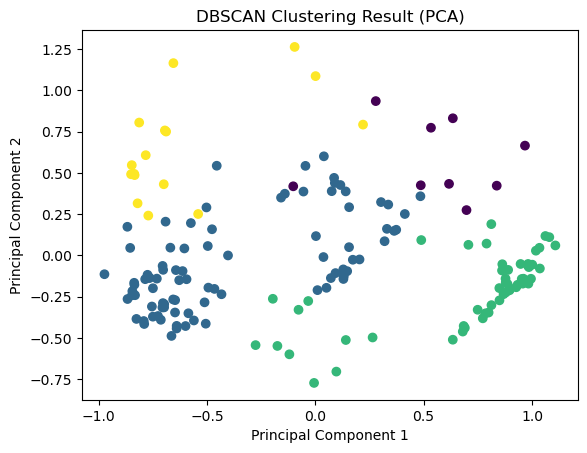

In [33]:
# Apply PCA to reduce the dimensionality
pca = PCA(n_components=3)
data_pca = pca.fit_transform(dbsdata)

# Plot the data points with colors representing their cluster labels
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering Result (PCA)')
plt.show()

In [34]:
# Define a dictionary to store decision trees for each cluster
classifiers = []
heart_data=train_set
# Iterate over unique cluster labels
for cluster_label in np.unique(dbscan.labels_):
    if(cluster_label==-1):
        continue
    # Filter the data for the current cluster
    cluster_data = heart_data[dbscan.labels_ == cluster_label]
    
    # Select the features and target for the decision tree
    features = cluster_data.iloc[:,:-1]
    target = cluster_data['output']
    
    # Create a decision tree classifier
    decision_tree = DecisionTreeClassifier()
    
    decision_tree.fit(features, target)
    classifiers.append(('cluster_' + str(cluster_label), decision_tree))


In [35]:
classifiers

[('cluster_0', DecisionTreeClassifier()),
 ('cluster_1', DecisionTreeClassifier()),
 ('cluster_2', DecisionTreeClassifier())]

In [36]:
voting_classifier = VotingClassifier(classifiers, voting='hard')

# Fit the Voting Classifier to the data
X = heart_data.iloc[:, :-1]
y = heart_data['output']
voting_classifier.fit(X, y)
test=heart_test
# Predict the class labels using the Voting Classifier
predictions = voting_classifier.predict(test.iloc[:,:-1])
print('Predictions:', predictions)

# Create a list to store the true labels
true_labels = test['output'].values

# Evaluate the performance of the voting classifier
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Print the evaluation metrics
print('Evaluation Metrics:')
print('-------------------')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')


Predictions: [1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0
 0 1 1 1 1]
Evaluation Metrics:
-------------------
Accuracy: 0.67
Precision: 0.50
Recall: 0.50
F1-Score: 0.50
